In [92]:
import os
import numpy as np

import analysis_plotting_helper_functions_c3v3 as helper
import analysis_utils as utils
import utils_c5

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [93]:
cohort = 'cohort_5'
exp = 'exp3'
data_dir = '/Users/rebekahzhang/data/behavior_data'
data_folder = os.path.join(data_dir, cohort, exp, 'full_clean')
figure_folder = os.path.join(data_dir, cohort, exp, 'figures')
print(data_folder)
print(figure_folder)

/Users/rebekahzhang/data/behavior_data/cohort_5/exp3/full_clean
/Users/rebekahzhang/data/behavior_data/cohort_5/exp3/figures


In [94]:
# two_colors = plt.cm.viridis(np.linspace(0, 1, 2))
two_colors = ["#ffb400", "#9080ff"]
custom_palette = {'s': two_colors[0], 'l': two_colors[1]}

In [95]:
colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", 
          "#beb9db", "#fdcce5", "#8bd3c7"]

# Session based plotting

### load session log

In [96]:
path = os.path.join(data_folder,f'sessions_training_{exp}.csv')

In [97]:
sessions_training = utils_c5.load_data(os.path.join(data_folder,f'sessions_training_{exp}.csv'))

In [98]:
sessions_training

,index,mouse,date,time,exp,training,rig,avg_tw,dir,group,num_blocks,num_trials,rewards,session_time,proper_end,session
5,59,RZ040,2024-01-30,12-16-28,3,regular,rig3,0.32,2024-01-30_12-16-28_RZ040,s,1.0,326.0,320.0,3610.88,True,0
6,60,RZ041,2024-01-30,12-55-14,3,regular,rig2,1.21,2024-01-30_12-55-14_RZ041,s,1.0,260.0,655.0,2401.00,True,0
7,61,RZ042,2024-01-30,13-25-11,3,regular,rig3,2.44,2024-01-30_13-25-11_RZ042,s,1.0,340.0,770.0,3613.18,True,0
8,62,RZ043,2024-01-30,13-40-30,3,regular,rig2,1.34,2024-01-30_13-40-30_RZ043,l,1.0,275.0,330.0,2402.22,True,0
9,63,RZ044,2024-01-30,14-23-31,3,regular,rig2,0.92,2024-01-30_14-23-31_RZ044,l,1.0,274.0,250.0,2400.16,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,665,RZ041,2024-04-12,13-18-01,3,regular,rig3,10.31,2024-04-12_13-18-01_RZ041,s,1.0,168.0,700.0,2830.04,True,55
612,666,RZ042,2024-04-12,13-30-26,3,regular,rig2,6.30,2024-04-12_13-30-26_RZ042,s,1.0,168.0,700.0,1987.29,True,55
613,667,RZ043,2024-04-12,14-05-46,3,regular,rig2,3.30,2024-04-12_14-05-46_RZ043,l,1.0,266.0,700.0,2267.27,True,55
614,668,RZ044,2024-04-12,14-07-59,3,regular,rig3,1.12,2024-04-12_14-07-59_RZ044,l,1.0,536.0,700.0,3744.34,True,55


make mouse list

In [99]:
mouse_list = utils_c5.generate_mouse_list(sessions_training)
print(mouse_list)

['RZ040', 'RZ041', 'RZ042', 'RZ043', 'RZ044', 'RZ045']


In [100]:
cohort_group = {"s": ['RZ040', 'RZ041', 'RZ042'], 
          "l": ['RZ043', 'RZ044', 'RZ045']}

### Plotting functions
should be moved to helper

In [101]:
def plot_each_mouse_per_line(data_df, column_name, plot_name, title, x_label, y_label, 
                             figure_folder=figure_folder, mouse_list=mouse_list):
    fig = plt.figure()
    for i, mouse in enumerate(mouse_list):
        session_mouse = data_df.loc[data_df.mouse == mouse]
        plt.plot(session_mouse.session, session_mouse[column_name], color=colors[i], label=mouse)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

In [102]:
def plot_overdays_colored_by_group(data_df, column_name, plot_name, title, x_label, y_label, 
                                   figure_folder=figure_folder, color_palette=custom_palette):
    fig = plt.figure()
    sns.lineplot(x="session",
                 y=column_name,
                 hue="group",
                 data=data_df,
                 palette=color_palette)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # plt.ylim(1,4)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

# Plot type of trials per session

### generate trial type df for plotting
Calculate proportions of trials types and generate trial type df

In [103]:
def generate_trial_type_df(training_session_log):
    for _, session_info in training_session_log.iterrows():
        all_trials = utils_c5.load_data(utils_c5.generate_trials_analyzed_path(data_folder, session_info))
        session_performance = helper.get_session_performance(all_trials)
        training_session_log.loc[training_session_log.dir == session_info['dir'], 
                                    ['miss_trials', 'good_trials']] = session_performance
    trial_type_df = training_session_log[['mouse', 'group', 'session', 'num_trials', 
                                            'miss_trials', 'good_trials']].copy()
    trial_type_df['p_miss'] = trial_type_df.miss_trials/trial_type_df.num_trials
    trial_type_df['p_good'] = trial_type_df.good_trials/trial_type_df.num_trials
    trial_type_df['p_accident'] = 1 - trial_type_df.p_good - trial_type_df.p_miss 
    return trial_type_df

In [104]:
trial_type_df = generate_trial_type_df(sessions_training)

### trial type combined plot

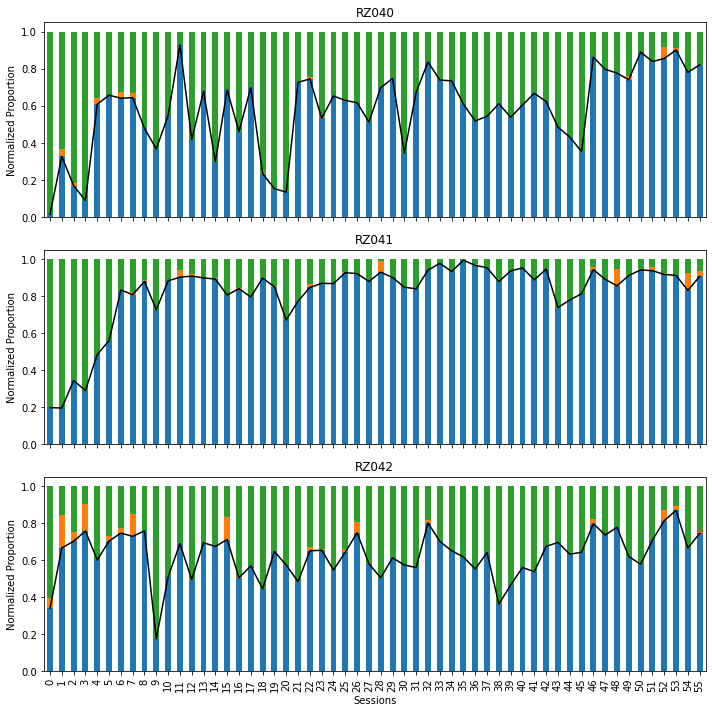

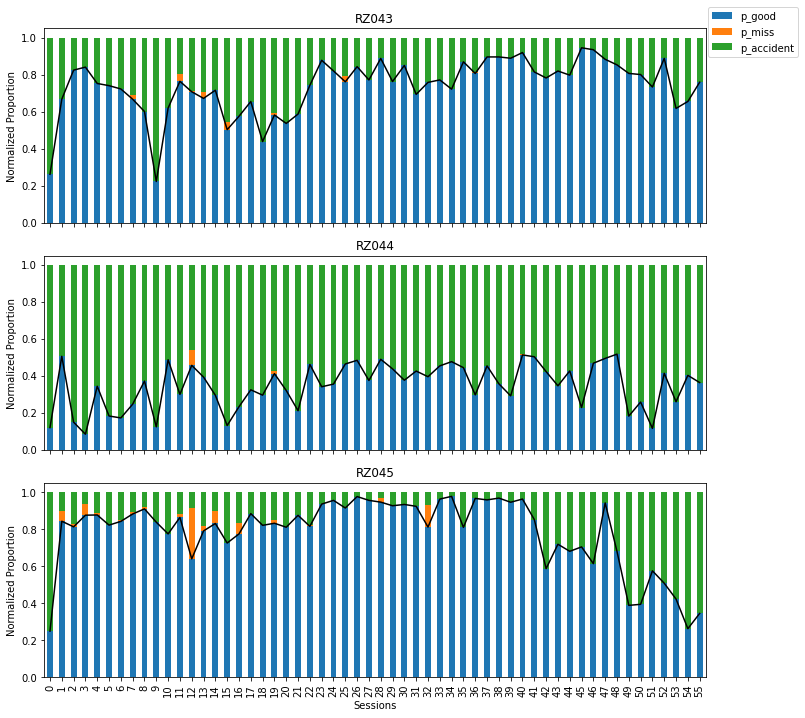

In [176]:
for group, mice in cohort_group.items():
  fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

  for i, mouse in enumerate(mice):
    session_mouse = trial_type_df.loc[(trial_type_df.mouse == mouse) & (trial_type_df.group == group)]
    to_plot = session_mouse.loc[:, ['session', 'p_good', 'p_miss', 'p_accident']]
    ax = axs.flat[i]
    to_plot.plot.bar(x='session', stacked=True, ax=ax, legend=None)
    ax.set_title(mouse)
    ax.set_xlabel('Sessions')
    ax.set_ylabel('Normalized Proportion')
    ax.plot(to_plot.session, to_plot.p_good, color='k', linewidth=1.5)
  
  if group == "l":
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.12, 1))
  plt.tight_layout()
  plt.savefig(f'{figure_folder}/engagement_plots_{group}.png', bbox_inches='tight')

### percentage good trials

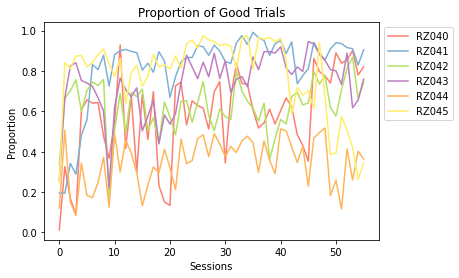

In [106]:
# plot the proportion of good trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_good', 
                         plot_name="%_good_trials", 
                         title='Proportion of Good Trials',
                         x_label='Sessions', 
                         y_label='Proportion')

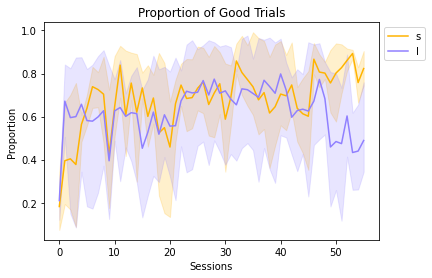

In [107]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_good", 
                               plot_name='%_good_trials_by_group', 
                               title='Proportion of Good Trials', 
                               x_label='Sessions', 
                               y_label='Proportion')

### Percent missed trials

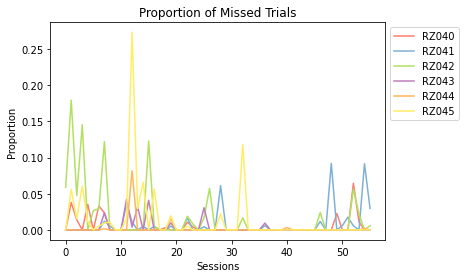

In [38]:
# plot the proportion of miss trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_miss', 
                         plot_name="%_miss_trials",
                         title='Proportion of Missed Trials', 
                         x_label='Sessions', 
                         y_label='Proportion')

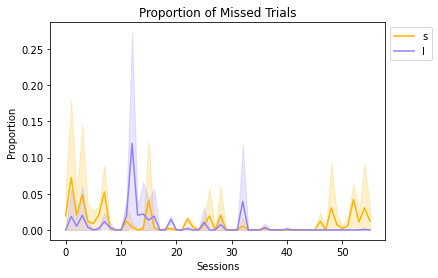

In [39]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_miss", 
                               plot_name='%_miss_trials_by_group', 
                               title='Proportion of Missed Trials', 
                               x_label='Sessions', 
                               y_label='Proportion')

### Percent accident trials

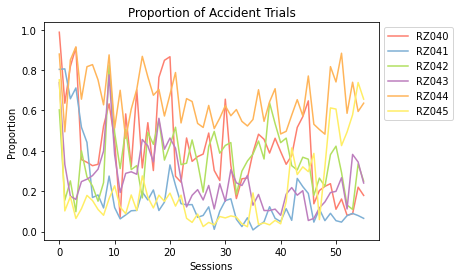

In [40]:
# plot the proportion of accident trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_accident', 
                         plot_name="%_accident_trials", 
                         title='Proportion of Accident Trials',
                         x_label='Sessions', 
                         y_label='Proportion')

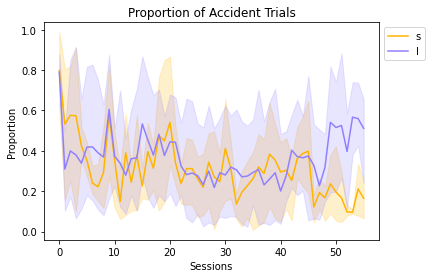

In [41]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_accident", 
                               plot_name='%_accident_trials_by_group', 
                               title='Proportion of Accident Trials', 
                               x_label='Sessions', 
                               y_label='Proportion')

# Plot rewards per session

### add info to training session log for plotting

In [42]:
sessions_training['reward_rate'] = sessions_training.rewards/sessions_training.session_time

In [43]:
sessions_training['reward_per_trial'] = sessions_training.rewards/sessions_training.num_trials

In [44]:
sessions_training['num_trials_rewarded'] = sessions_training.rewards/5

In [45]:
sessions_training['%_trials_rewarded'] = sessions_training.num_trials_rewarded/sessions_training.num_trials

### plot % rewarded trials

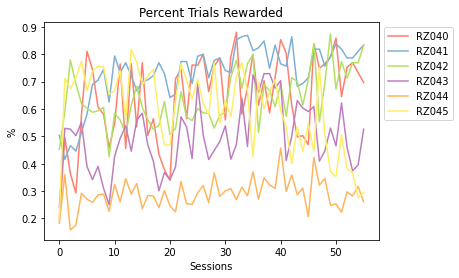

In [46]:
plot_each_mouse_per_line(data_df=sessions_training, 
                         column_name='%_trials_rewarded', 
                         plot_name="%_trials_rewarded",
                         title='Percent Trials Rewarded', 
                         x_label='Sessions', 
                         y_label='%')

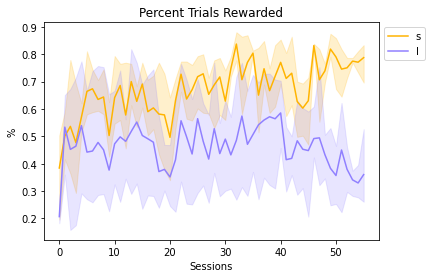

In [47]:
plot_overdays_colored_by_group(data_df=sessions_training, 
                               column_name="%_trials_rewarded", 
                               plot_name='%_trials_rewarded_by_group', 
                               title='Percent Trials Rewarded', 
                               x_label='Sessions', 
                               y_label='%')

### Plot reward rate

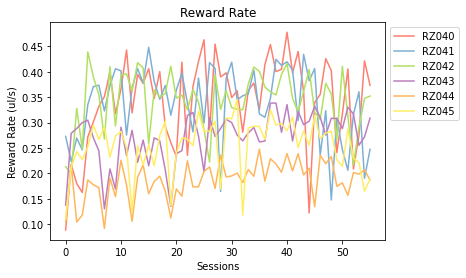

In [48]:
# plot the reward rate
plot_each_mouse_per_line(data_df=sessions_training, 
                         column_name='reward_rate', 
                         plot_name="reward_rate",
                         title='Reward Rate', 
                         x_label='Sessions', 
                         y_label='Reward Rate (ul/s)')

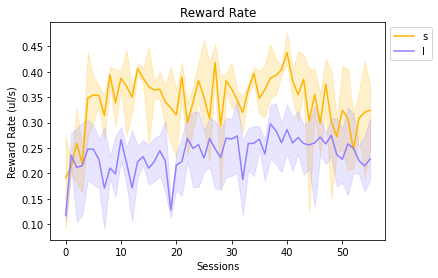

In [49]:
plot_overdays_colored_by_group(data_df=sessions_training, 
                               column_name="reward_rate", 
                               plot_name='reward_rate_by_group', 
                               title='Reward Rate', 
                               x_label='Sessions', 
                               y_label='Reward Rate (ul/s)')

### Plot session length

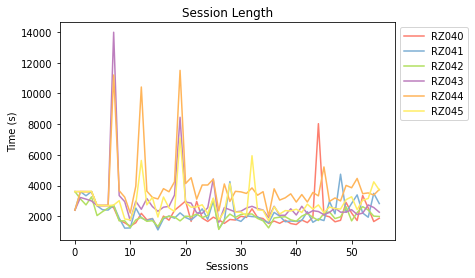

In [50]:
# plot the session length
plot_each_mouse_per_line(data_df=sessions_training, 
                         column_name='session_time', 
                         plot_name="session_length", 
                         title='Session Length',
                         x_label='Sessions', 
                         y_label='Time (s)')

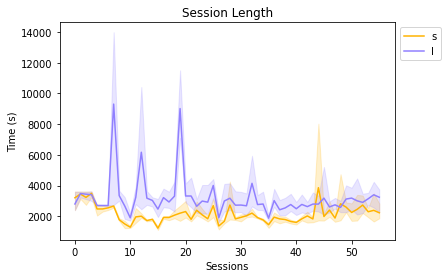

In [51]:
plot_overdays_colored_by_group(data_df=sessions_training, 
                               column_name="session_time", 
                               plot_name='session_length_by_group', 
                               title='Session Length', 
                               x_label='Sessions', 
                               y_label='Time (s)')

### plot num trials completed

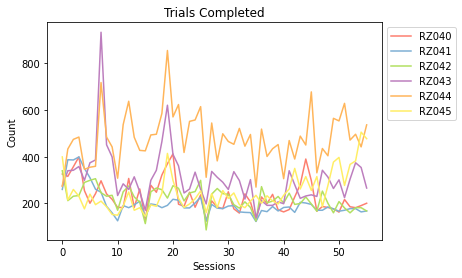

In [52]:
# plot the number of trials completed
plot_each_mouse_per_line(data_df=sessions_training, 
                         column_name='num_trials', 
                         plot_name="num_trials", 
                         title='Trials Completed',
                         x_label='Sessions', 
                         y_label='Count')

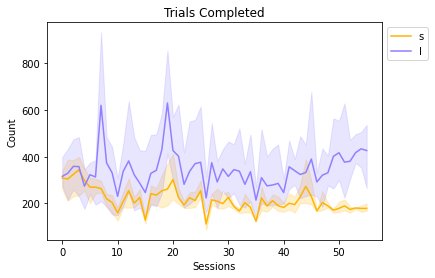

In [53]:
plot_overdays_colored_by_group(data_df=sessions_training, 
                               column_name="num_trials", 
                               plot_name='num_trials_by_group', 
                               title='Trials Completed', 
                               x_label='Sessions', 
                               y_label='Count')

# Plot background behavior

### generate mistake df for plotting

In [54]:
def get_session_mistakes(all_trials):
    all_trials['bg_repeats'] -= 1
    num_bg_repeats_mean = all_trials.bg_repeats.mean()
    num_bg_repeats_med = all_trials.bg_repeats.median()
    num_bg_repeats_std = all_trials.bg_repeats.std()
    num_bg_repeats_rate_mean = num_bg_repeats_mean/all_trials.bg_length.mean()
    return [num_bg_repeats_mean, num_bg_repeats_med, num_bg_repeats_std, num_bg_repeats_rate_mean]

In [55]:
def generate_mistake_df(training_session_log):
    mistake_df = training_session_log[['mouse', 'session', 'dir', 'group']].copy()

    for _, session_info in training_session_log.iterrows():
        all_trials = utils_c5.load_data(utils_c5.generate_trials_analyzed_path(data_folder, session_info))
        # time waited for all trials
        session_mistakes = get_session_mistakes(all_trials)
        mistake_df.loc[mistake_df.dir == session_info['dir'], 
                                ['num_bg_repeats_mean', 'num_bg_repeats_med', 
                                 'num_bg_repeats_std', 'num_bg_repeats_rate_mean']] = session_mistakes
    return mistake_df

In [56]:
mistakes_df = generate_mistake_df(sessions_training)

### plot number of mistakes per trial

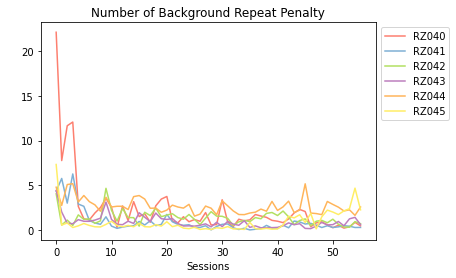

In [57]:
plot_each_mouse_per_line(data_df=mistakes_df, 
                         column_name='num_bg_repeats_mean', 
                         plot_name="num_bg_repeats_mean", 
                         title='Number of Background Repeat Penalty',
                         x_label='Sessions', 
                         y_label=' ')

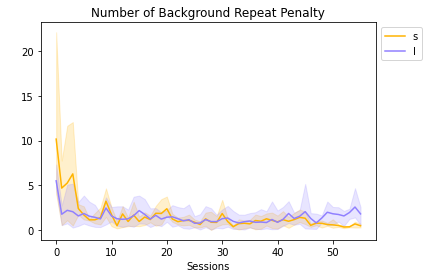

In [58]:
plot_overdays_colored_by_group(data_df=mistakes_df, 
                               column_name="num_bg_repeats_mean", 
                               plot_name='num_bg_repeats_mean_by_group', 
                               title='Number of Background Repeat Penalty', 
                               x_label='Sessions', 
                               y_label=' ')

### plot mistake rate

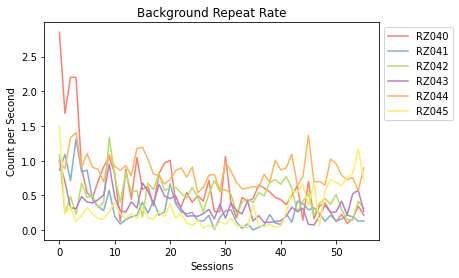

In [59]:
plot_each_mouse_per_line(data_df=mistakes_df, 
                         column_name='num_bg_repeats_rate_mean', 
                         plot_name="num_bg_repeats_rate_mean", 
                         title='Background Repeat Rate',
                         x_label='Sessions', 
                         y_label='Count per Second')

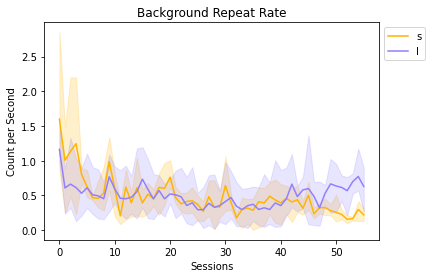

In [60]:
plot_overdays_colored_by_group(data_df=mistakes_df, 
                               column_name="num_bg_repeats_rate_mean", 
                               plot_name='num_bg_repeats_rate_mean_by_group', 
                               title='Background Repeat Rate', 
                               x_label='Sessions', 
                               y_label='Count per Second')

# Plot time wait behavior

### generate wait df for plotting

In [61]:
def generate_wait_df(training_session_log):
    wait_df = training_session_log[['mouse', 'session', 'dir', 'group']].copy()

    for _, session_info in training_session_log.iterrows():
        all_trials = utils_c5.load_data(utils_c5.generate_trials_analyzed_path(data_folder, session_info))
        # time waited for all trials
        session_tw = helper.get_session_tw(all_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean', 'tw_median', 'tw_stdev']] = session_tw

        good_trials = utils.select_good_trials(all_trials)
         # time waited for good trials
        session_tw_g = helper.get_session_tw(good_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean_g', 'tw_median_g', 'tw_stdev_g']] = session_tw_g
    return wait_df

In [62]:
wait_df = generate_wait_df(sessions_training)

### plot time watied

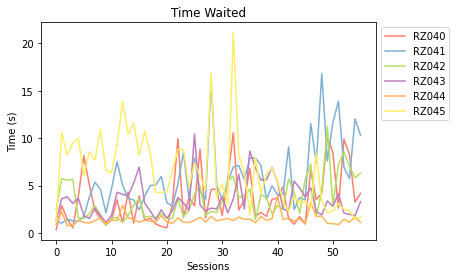

In [63]:
# plot the time waited over days. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_mean', 
                         plot_name="tw_mean", 
                         title='Time Waited',
                         x_label='Sessions', 
                         y_label='Time (s)')

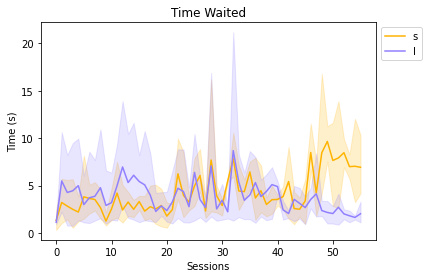

In [64]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_mean", 
                               plot_name='tw_mean_by_group', 
                               title='Time Waited', 
                               x_label='Sessions', 
                               y_label='Time (s)')

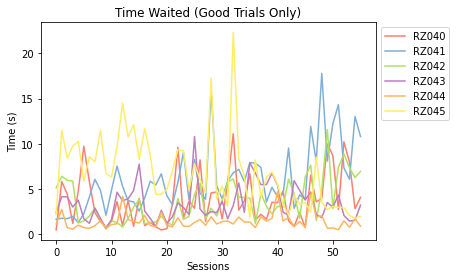

In [65]:
# plot the time waited over days good trials only. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_mean_g', 
                         plot_name="tw_mean_g", 
                         title='Time Waited (Good Trials Only)',
                         x_label='Sessions', 
                         y_label='Time (s)')

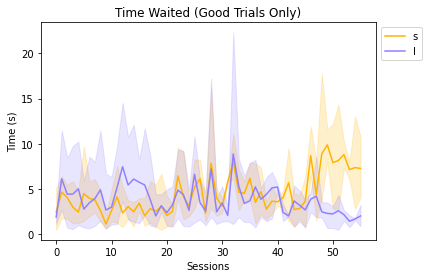

In [66]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_mean_g", 
                               plot_name='tw_mean_g_by_group', 
                               title='Time Waited (Good Trials Only)', 
                               x_label='Sessions', 
                               y_label='Time (s)')

## some stats

all sessions tw difference

In [122]:
short = wait_df[wait_df['group']=='s']
long = wait_df[wait_df['group']=='l']

print(short.tw_mean.mean())
print(long.tw_mean.mean())

#perform independent two sample t-test
stats.ttest_ind(short['tw_mean'], long['tw_mean'])

4.31400789361247
3.8120111772792753


Ttest_indResult(statistic=1.4557708931290243, pvalue=0.1463952535092668)

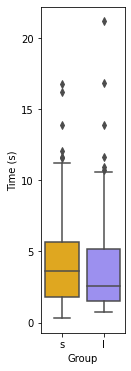

In [129]:
plt.figure(figsize=(1.5, 6))
sns.boxplot(data=wait_df, x="group", y="tw_mean", palette=custom_palette)
plt.ylabel("Time (s)")
plt.xlabel("Group")
plt.savefig(f'{figure_folder}/{"tw_box"}.png', bbox_inches='tight')

by days sessions tw difference

In [199]:
def generate_p_val_df(wait_df, group_col_name):
    result_list = []
    for num, data in wait_df.groupby(group_col_name):
        short = data[data['group']=='s']
        long = data[data['group']=='l']
        s_tw = short.tw_mean.mean()
        l_tw = long.tw_mean.mean()

        # Perform t-test
        ttest = stats.ttest_ind(short['tw_mean'], long['tw_mean'])
        p_val_t = ttest[1]

        # Perform Mann-Whitney U test
        u_test = stats.mannwhitneyu(short['tw_mean'], long['tw_mean'])
        p_val_u = u_test[1]

        result_list.append([num, s_tw, l_tw, p_val_t, p_val_u])

    return pd.DataFrame(result_list, columns=["num", "s_tw", "l_tw", "p_val_t", "p_val_u"])

In [200]:
tw_stats_by_session = generate_p_val_df(wait_df, "session")

In [201]:
tw_stats_by_session[tw_stats_by_session['p_val_t'] < 0.05]

,num,s_tw,l_tw,p_val_t,p_val_u
31,31,5.497899,2.231757,0.001983,0.1
46,46,8.488187,3.538947,0.040988,0.1
49,49,9.656280,2.164085,0.004263,0.1
52,52,8.467685,2.011790,0.002021,0.1
53,53,6.997996,1.814459,0.003181,0.1


plot waiting df in 10 day intervals

In [148]:
wait_df['period'] = wait_df['session']//10 #add session period in 10 day intervals

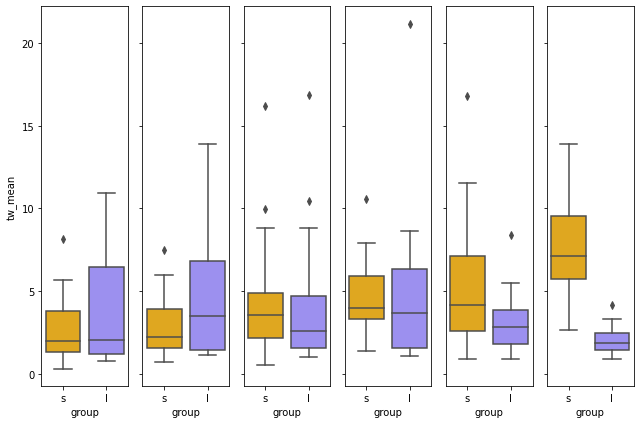

In [182]:
num_subplots = wait_df['period'].max()+1
fig, axs = plt.subplots(1, num_subplots, figsize=(num_subplots*1.5, 6), sharey=True)
for p, period_data in wait_df.groupby('period'):
    sns.boxplot(data=period_data,
                x="group", 
                y="tw_mean", 
                palette=custom_palette,
                ax=axs.flat[p])
    if p != 0:
        axs.flat[p].set_ylabel("")

plt.tight_layout()
plt.savefig(f'{figure_folder}/tw_box_by_period.png', bbox_inches='tight')

In [198]:
tw_stats_by_period = generate_p_val_df(wait_df, "period")
tw_stats_by_period[tw_stats_by_period['p_val_t'] < 0.05]

,num,s_tw,l_tw,p_val_t,p_val_u
1,1,2.874656,4.616182,2.283257e-02,0.108690
4,4,5.209583,3.093051,5.447750e-03,0.010315
5,5,7.498730,2.041686,5.795780e-08,0.000001


## plots to be figured out

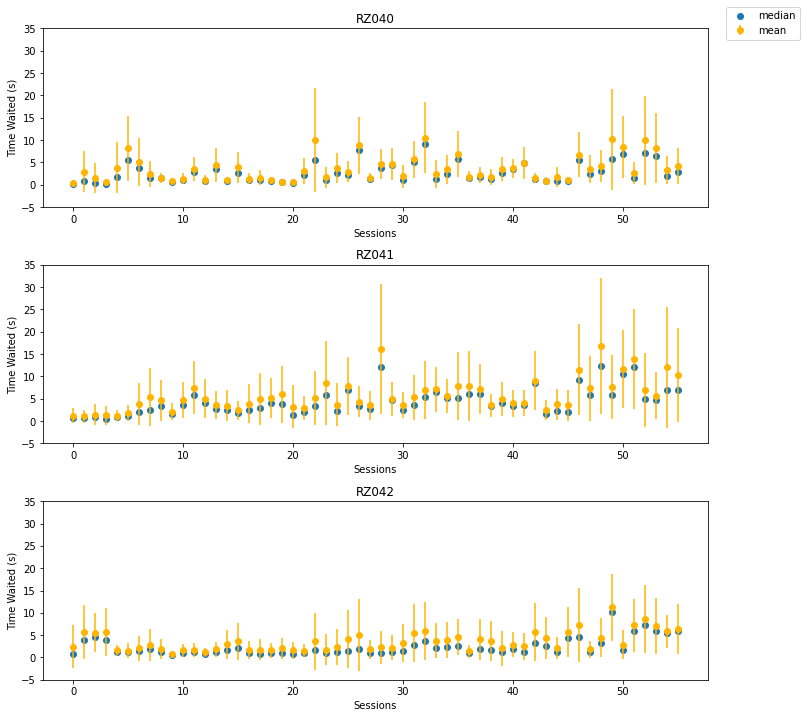

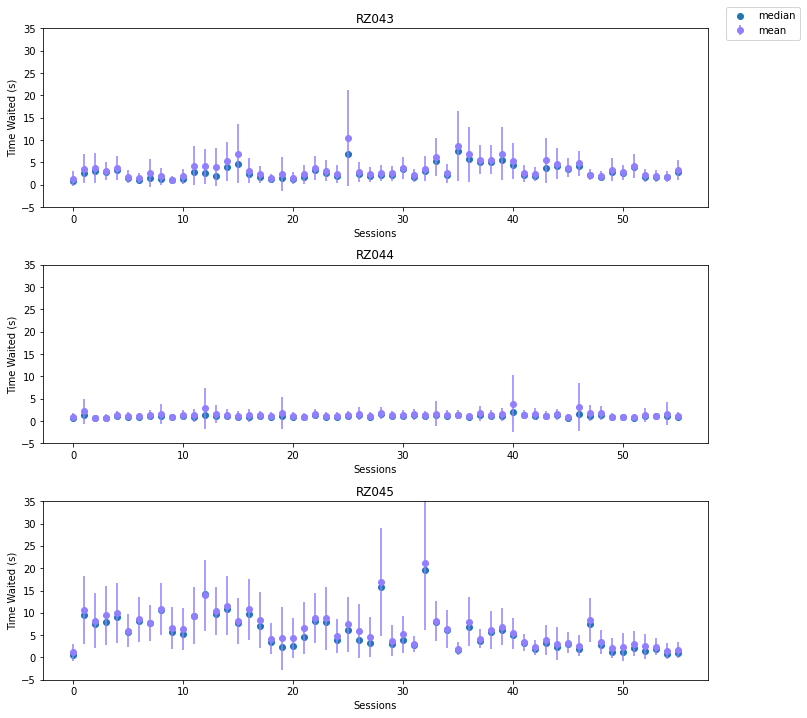

In [108]:
for group, mice in cohort_group.items():
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))
    for i, mouse in enumerate(mice):
        session_mouse = wait_df.loc[(wait_df.mouse == mouse) & (wait_df.group == group)]
        ax = axs.flat[i]
        ax.errorbar(session_mouse.session, session_mouse.tw_mean, session_mouse.tw_stdev, 
                    linestyle='None', marker='o', color=custom_palette[group], label='mean')
        ax.scatter(session_mouse.session, session_mouse.tw_median, label='median')
        ax.set_ylim([-5,35])
        ax.set_title(mouse)
        ax.set_xlabel('Sessions')
        ax.set_ylabel('Time Waited (s)')
        # ax.set_ylim(0,7.5)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.12, 1))
    plt.tight_layout()
    plt.savefig(f'{figure_folder}/tw_plots_{group}.png', bbox_inches='tight', dpi=300)

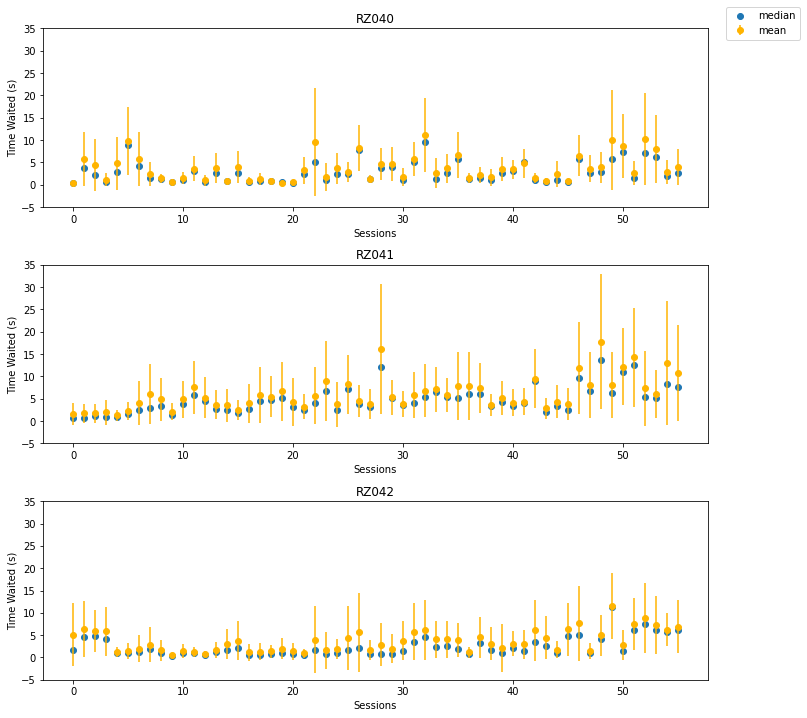

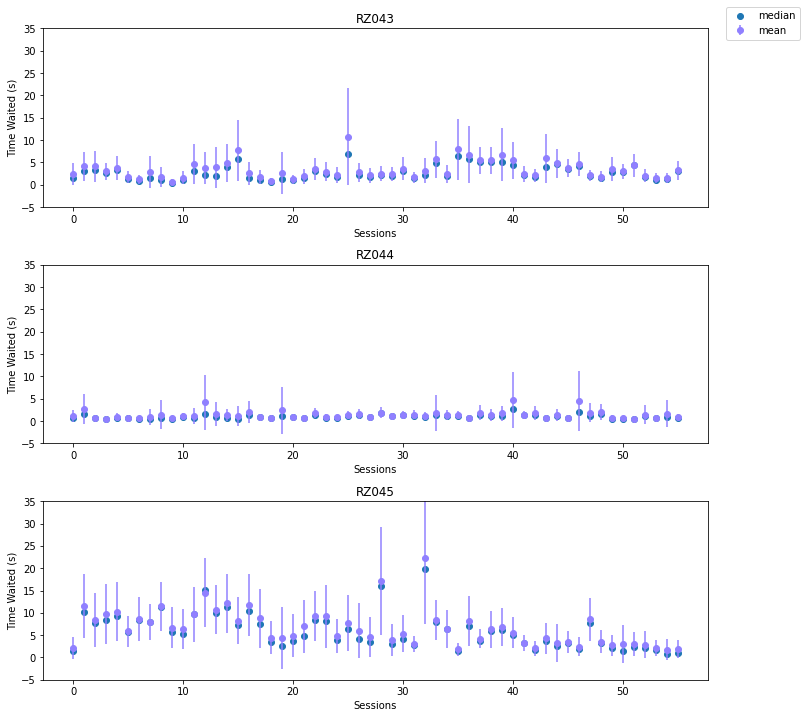

In [109]:
for group, mice in cohort_group.items():
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))
    for i, mouse in enumerate(mice):
        session_mouse = wait_df.loc[(wait_df.mouse == mouse) & (wait_df.group == group)]
        ax = axs.flat[i]
        ax.errorbar(session_mouse.session, session_mouse.tw_mean_g, session_mouse.tw_stdev_g, 
                    linestyle='None', marker='o', color=custom_palette[group], label='mean')
        ax.scatter(session_mouse.session, session_mouse.tw_median_g, label='median')
        ax.set_ylim([-5,35])
        ax.set_title(mouse)
        ax.set_xlabel('Sessions')
        ax.set_ylabel('Time Waited (s)')
        # ax.set_ylim(0,7.5)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.12, 1))
    plt.tight_layout()
    plt.savefig(f'{figure_folder}/tw_good_plots_{group}.png', bbox_inches='tight', dpi=300)

In [110]:
def calculate_subplot_row_col(session_mouse, plots_per_row):
    days_trained = len(session_mouse)
    num_rows = (days_trained - 1) // plots_per_row + 1
    num_cols = min(days_trained, plots_per_row)
    return num_rows, num_cols

In [111]:
for mouse in mouse_list:
    session_mouse = sessions_training.loc[sessions_training.mouse == mouse]
    num_rows, num_cols = calculate_subplot_row_col(session_mouse, 8)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(21.5, 2.5 * num_rows))

    for i, (_, session_info) in enumerate(session_mouse.iterrows()):
        all_trials = utils_c5.load_data(utils_c5.generate_trials_analyzed_path(data_folder, session_info))
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
        
        sns.scatterplot(x="session_trial_num",
                        y="time_waited",
                        hue="group",
                        data=all_trials,
                        palette=custom_palette,
                        ax=axs.flat[i])
        ax.set_ylim([0,35])
        ax.set_title(f'Session {i}')
        ax.legend().remove()
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/trial_num_vs_tw_{mouse}.png', bbox_inches='tight', dpi=300)
    plt.close()

# Stitched all sessions all mice per day

In [112]:
stitched_folder = os.path.join(data_dir, cohort, exp, 'stitched')
stitched_figure_folder = os.path.join(data_dir, cohort, exp, 'figures')
print(data_folder)
print(figure_folder)

/Users/rebekahzhang/data/behavior_data/cohort_5/exp3/full_clean
/Users/rebekahzhang/data/behavior_data/cohort_5/exp3/figures


In [113]:
stitched_log = utils.load_session_log(stitched_folder, f'sessions_training_stitched_{exp}.csv')

In [114]:
def generate_events_processed_stitched_path(data_folder, session_info):
    filename = f'events_processed_stitched_{session_info.date}.csv'
    return os.path.join(data_folder, f"{session_info.date}", filename)

In [115]:
def generate_trials_analyzed_stitched_path(data_folder, session_info):
    filename = f'trials_analyzed_stitched_{session_info.date}.csv'
    return os.path.join(data_folder, session_info.date, filename)

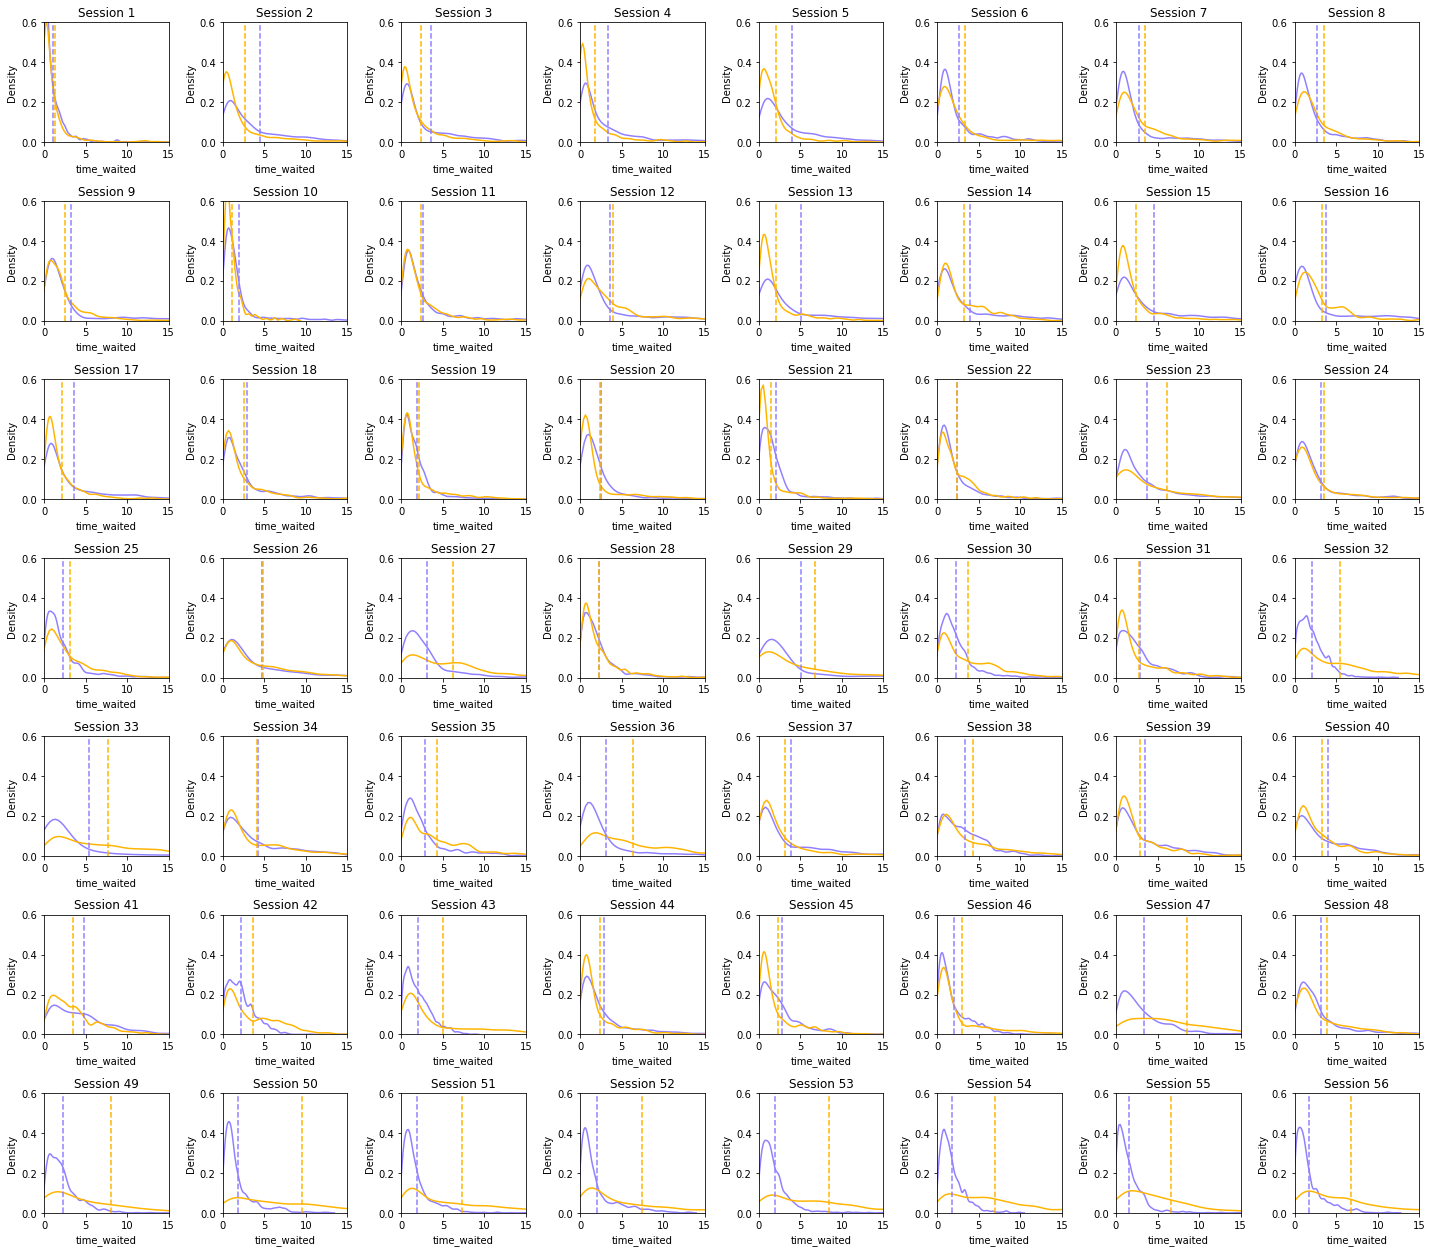

In [118]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 8 + 1
num_cols = min(days_trained, 8)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 2.5 * num_rows))

for i, (_, session_info) in enumerate(stitched_log.iterrows()):
    all_trials = utils_c5.load_data(generate_trials_analyzed_stitched_path(stitched_folder, session_info))
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.kdeplot(data=all_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="group",
                    common_norm=False,
                    bw_adjust=0.5, 
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.axvline(x=all_trials.loc[all_trials.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
    ax.axvline(x=all_trials.loc[all_trials.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
    ax.set_xlim([0, 15])
    ax.set_ylim([0, 0.6])
    ax.set_title(f'Session {i+1}')
    
# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{stitched_figure_folder}/tw_kde.png', bbox_inches='tight', dpi=300)

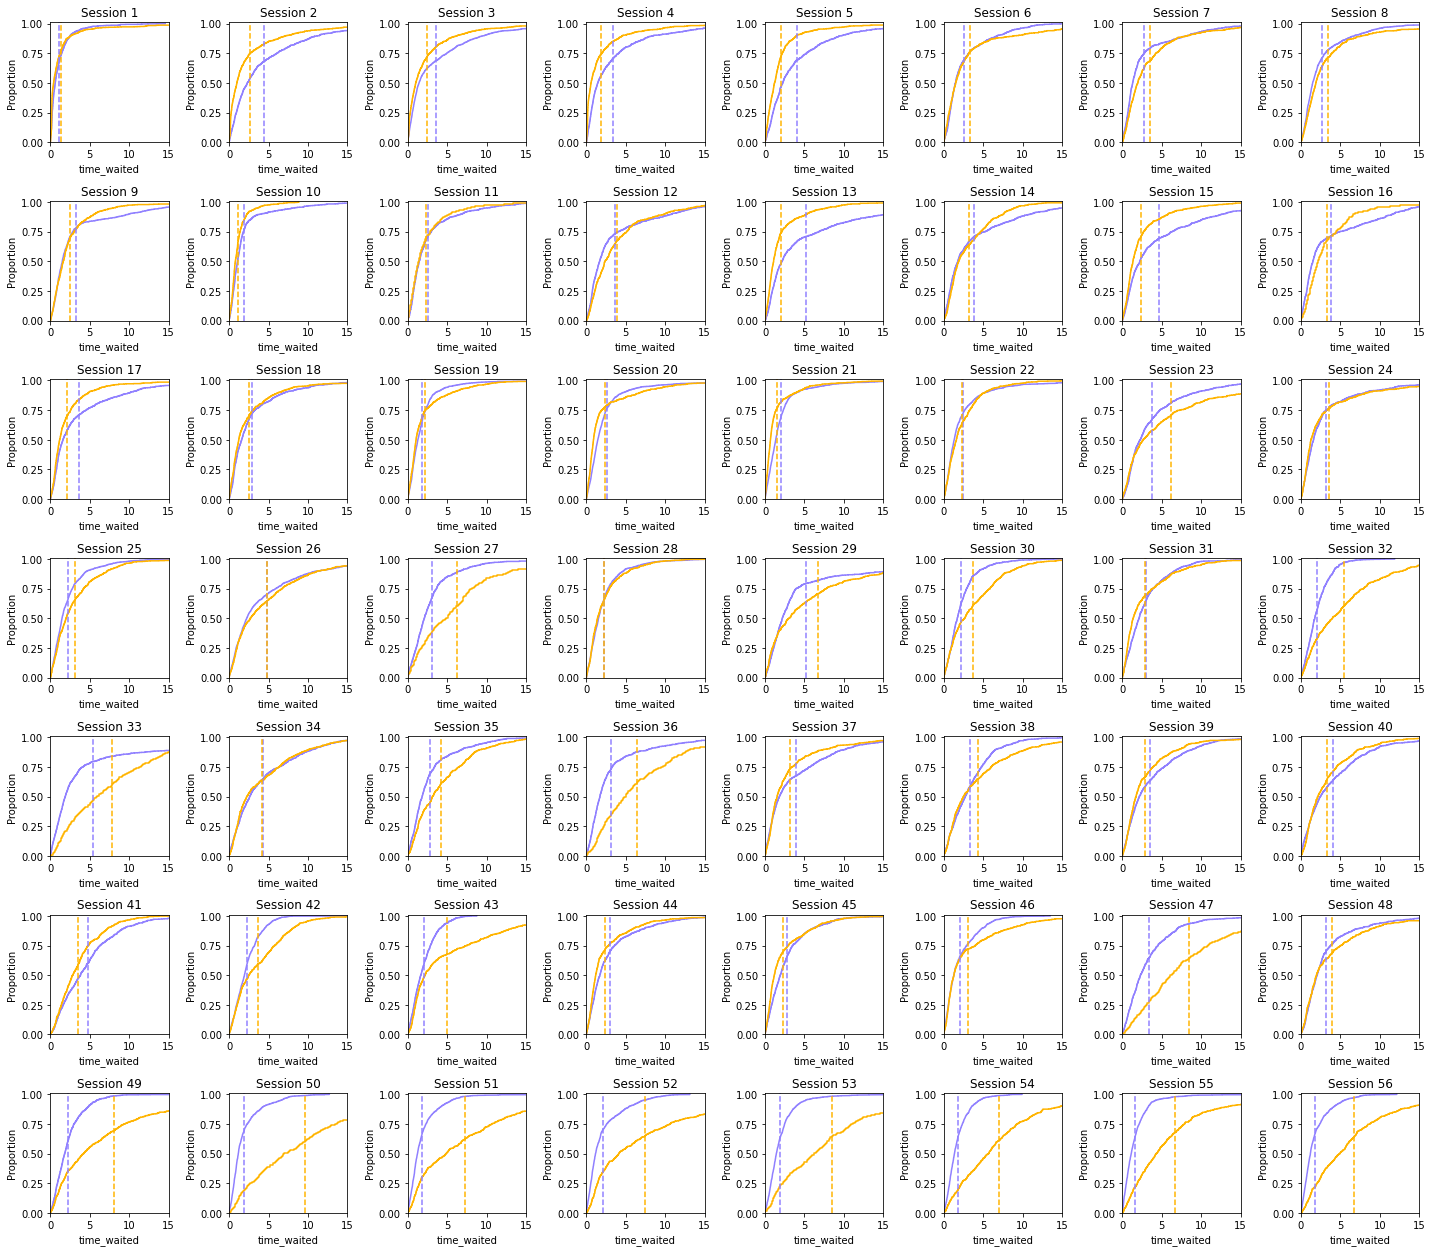

In [72]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 8 + 1
num_cols = min(days_trained, 8)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 2.5 * num_rows))

for i, (_, session_info) in enumerate(stitched_log.iterrows()):
    all_trials = utils_c5.load_data(generate_trials_analyzed_stitched_path(stitched_folder, session_info))
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.ecdfplot(data=all_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="group",
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.axvline(x=all_trials.loc[all_trials.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
    ax.axvline(x=all_trials.loc[all_trials.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
    
    ax.set_xlim([0, 15])
    ax.set_ylim([0, 1.01])
    
    ax.set_title(f'Session {i+1}')
    
# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{stitched_figure_folder}/tw_cdf.png', bbox_inches='tight', dpi=300)

In [119]:
def select_non_accident_trials(all_trials):
    non_accident_trials = all_trials[all_trials['time_waited'] > 0.5]
    return non_accident_trials

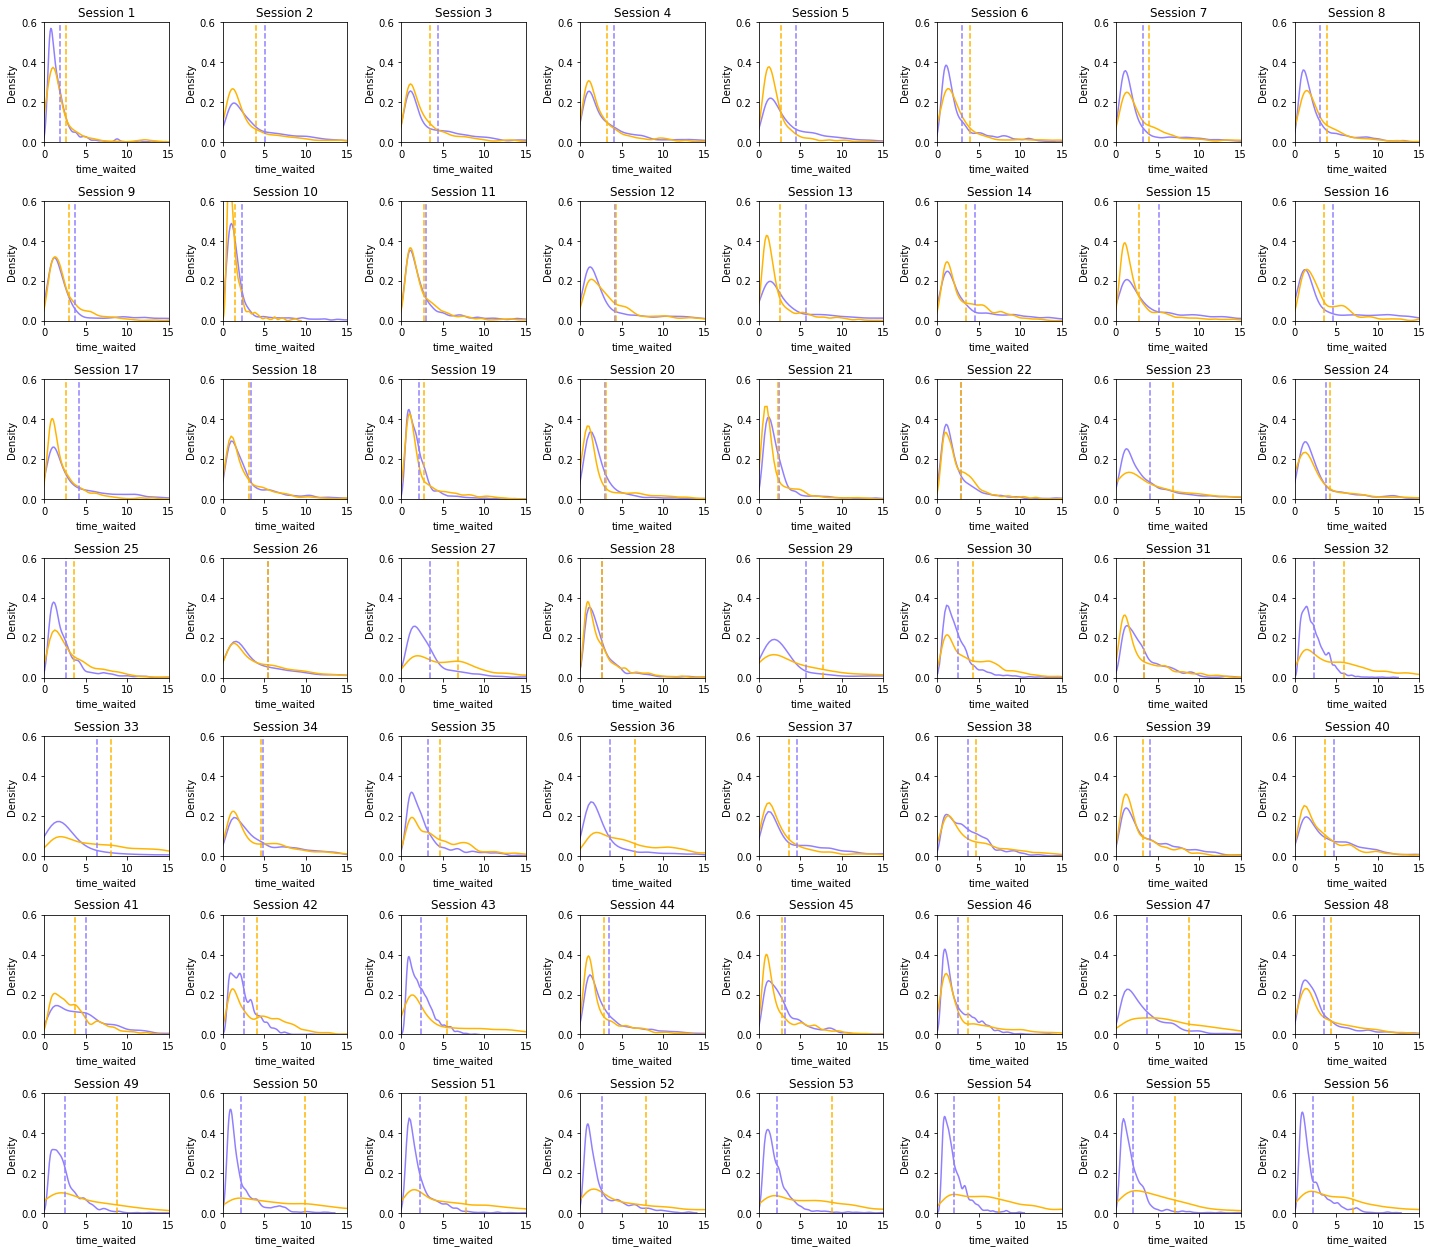

In [120]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 8 + 1
num_cols = min(days_trained, 8)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 2.5 * num_rows))

for i, (_, session_info) in enumerate(stitched_log.iterrows()):
    all_trials = utils_c5.load_data(generate_trials_analyzed_stitched_path(stitched_folder, session_info))
    non_accident_trials = select_non_accident_trials(all_trials)
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.kdeplot(data=non_accident_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="group",
                    common_norm=False,
                    bw_adjust=0.5, 
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.axvline(x=non_accident_trials.loc[non_accident_trials.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
    ax.axvline(x=non_accident_trials.loc[non_accident_trials.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
    
    ax.set_xlim([0, 15])
    ax.set_ylim([0, 0.6])
    
    ax.set_title(f'Session {i+1}')

# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{stitched_figure_folder}/tw_g_kde.png', bbox_inches='tight', dpi=300)

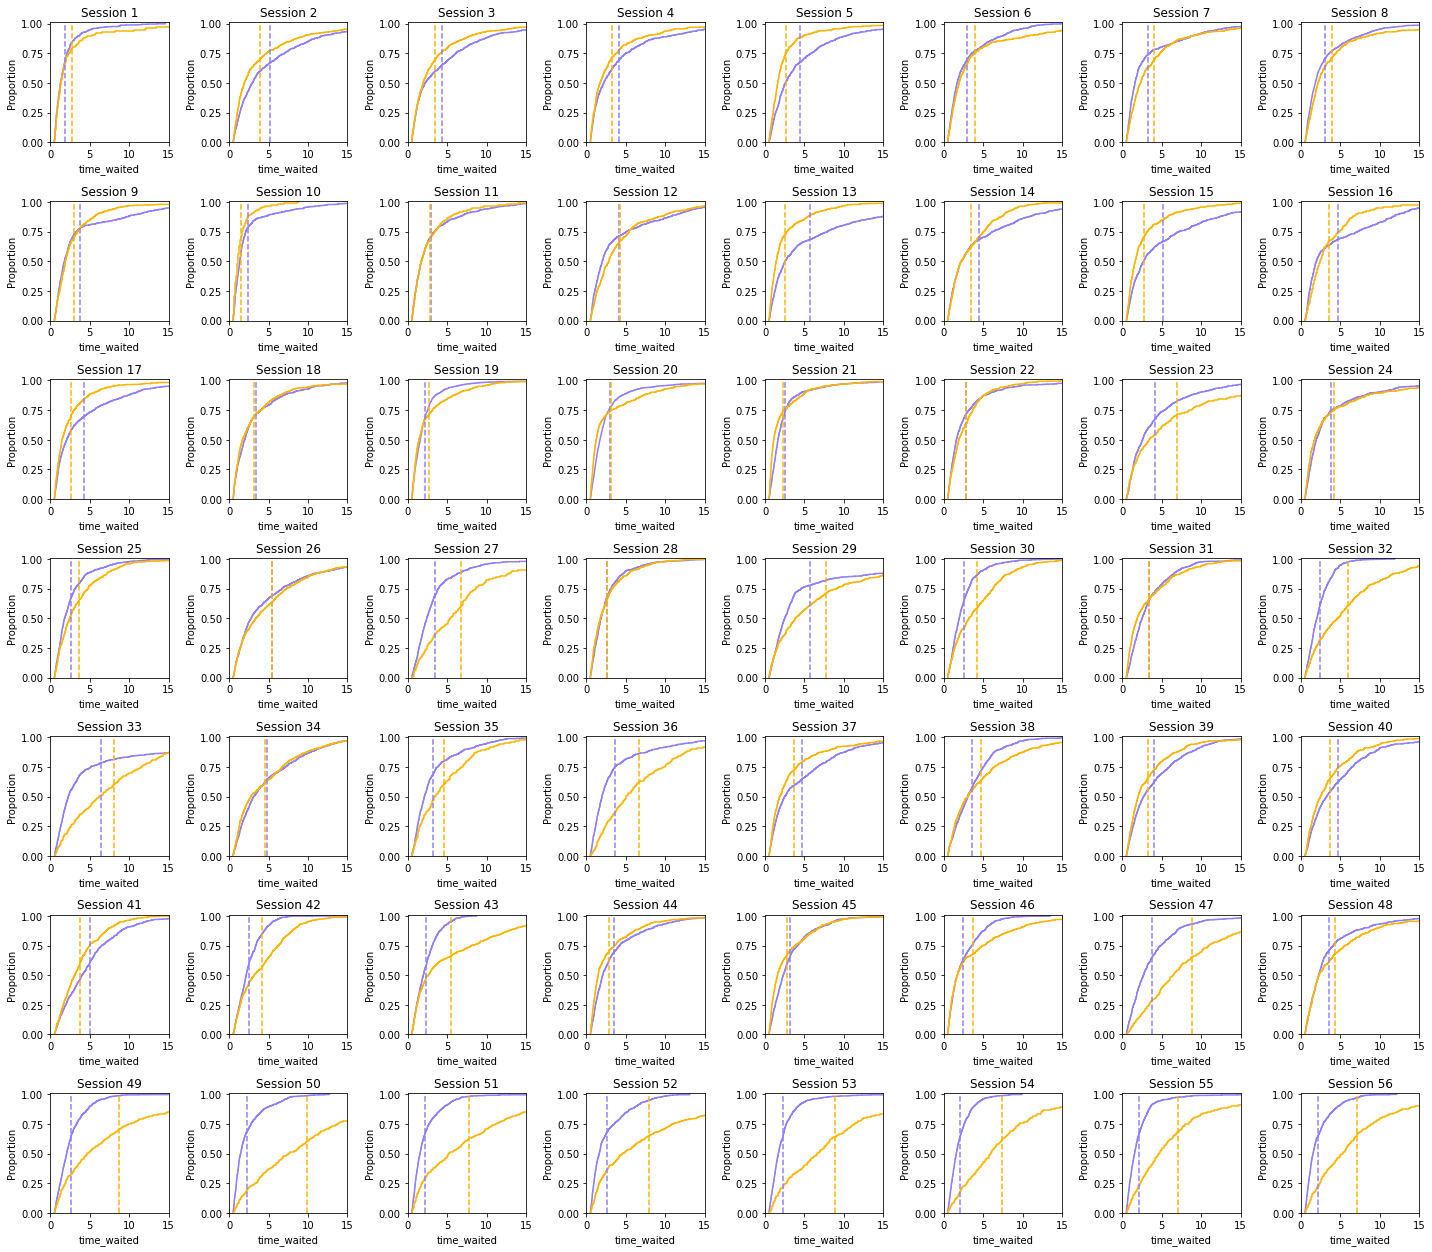

In [121]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 8 + 1
num_cols = min(days_trained, 8)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 2.5 * num_rows))

for i, (_, session_info) in enumerate(stitched_log.iterrows()):
    all_trials = utils_c5.load_data(generate_trials_analyzed_stitched_path(stitched_folder, session_info))
    non_accident_trials = select_non_accident_trials(all_trials)
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.ecdfplot(data=non_accident_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="group",
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.axvline(x=non_accident_trials.loc[non_accident_trials.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
    ax.axvline(x=non_accident_trials.loc[non_accident_trials.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
    
    ax.set_xlim([0, 15])
    ax.set_ylim([0, 1.01])
    
    ax.set_title(f'Session {i+1}')

# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{stitched_figure_folder}/tw_g_cdf.png', bbox_inches='tight', dpi=300)